In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Conv1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
import keras
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
sst_home='drive/My Drive/NLP GRUPO/'

Mounted at /content/drive


# Lectura de datos

In [32]:
data = pd.read_csv(sst_home+"/PARMEX_2022-main/parmex_train.csv") # 7601

text_1_df = data["Text1"]
text_2_df = data["Text2"]
label_df = data["Label"]

In [33]:
data.head()

,Text1,Text2,Label
0,"su nombre proviene de los persas, los cuales e...","el alimento, cuyo nombre proviene de los persa...",1
1,"la congelación con deshidratación, uno de los ...","un método de cocción es el sous vide, que mant...",0
2,"la empresa de catering caterers bubble, de lon...",el festival de alcachofa ahumada instantánea ...,0
3,el sous vide es un método de cocción que manti...,estos se usan para referir a las transformacio...,0
4,el cuidado de la piel también es un factor a t...,la dieta general de la gente consiste en carne...,0


# Analisis de datos

La diferencia entre las clases, mostrada en la celda anterior, puede afectar al rendimiento del modelo. Por ello, se hará un primer entrenamiento sin balanceo de clases y otro con el dataset balanceado para ver si la diferencia del rendimiento es muy notable.

Positivos = 1501
Negativos = 6100
----------------------------


([<matplotlib.patches.Wedge at 0x7ff441c65e10>,
 [Text(-0.8950215254763844, 0.6394814062456594, 'Negative'),
  Text(0.8950215554126681, -0.6394813643466777, 'Positive')])

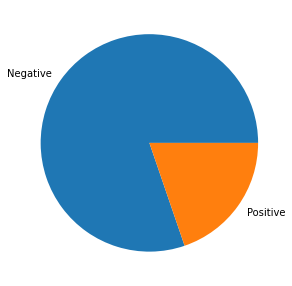

In [34]:
print("Positivos =", len(data[data["Label"] == 1]))
print("Negativos =", len(data[data["Label"] == 0]))
print("----------------------------")

fig = plt.figure(figsize =(5, 5))
plot_data = [len(data[data["Label"] == 0]), len(data[data["Label"] == 1])]
plt.pie(plot_data, labels = ["Negative", "Positive"])

In [35]:
import numpy as np
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 3. Modelo CNN  

In [36]:
import re
#nltk.download('stopwords')
from nltk.corpus import stopwords
 
X=[] #list to save the texts
 

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    return text

tokens=[]
for i, text in text_1_df.items(): 
    tok_1 = clean_text(text)
    tok_2 = clean_text(text_2_df[i])
    tok_3 = tok_1 + tok_2
    tokens.append(tok_3)

X=list(tokens)
print(len(X),len(label_df))


7601 7601


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, label_df, test_size=0.2, random_state=42)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

#we add a word index for the pad tokens
tokenizer.word_index['<PAD>'] = 0
print("Vocabulary size of the training={}".format(len(tokenizer.word_index)))
print("Number of Documents in the training={}".format(tokenizer.document_count))

Vocabulary size of the training=6193
Number of Documents in the training=6080


In [39]:
# We now transform the words to indexes

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
print(X_train[0].split())
print(train_sequences[0])

['las', 'tres', 'ruedas', 'tienen', 'alma', 'metlica', 'para', 'soportar', 'el', 'peso', 'y', 'estn', 'forradas', 'de', 'hule', 'o', 'caucho', 'vulcanizado', 'para', 'contrarrestar', 'la', 'friccinel', 'carrito', 'lleva', 'dos', 'productos', 'especficos', 'camotes', 'y', 'pltanos']
[14, 198, 234, 59, 173, 486, 16, 387, 5, 115, 8, 112, 448, 2, 407, 23, 313, 393, 16, 504, 3, 1513, 33, 1514, 169, 65, 2047, 35, 8, 43]


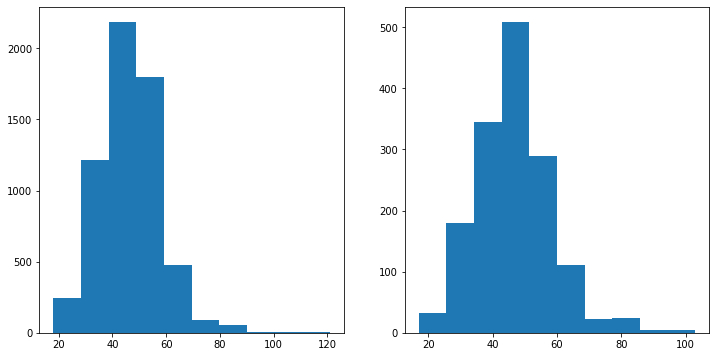

In [40]:
# The following graph shows the size distribution (number of tokens) of the review

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [41]:
MAX_SEQUENCE_LENGTH = 70

# pad dataset to a maximum review length in words
from tensorflow.keras.preprocessing import sequence

train_seq_pad = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_seq_pad = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_seq_pad.shape, test_seq_pad.shape

((6080, 70), (1521, 70))

In [42]:
print("length of the first sentence", len(train_sequences[0]), "after padding/trunking:", len(train_seq_pad[0]))
#print(X_train[0])
print(train_seq_pad[0])

length of the first sentence 30 after padding/trunking: 70
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   14  198
  234   59  173  486   16  387    5  115    8  112  448    2  407   23
  313  393   16  504    3 1513   33 1514  169   65 2047   35    8   43]


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding


import tensorflow as tf
tf.random.set_seed(1)

VOCAB_SIZE = len(tokenizer.word_index)

EMBED_SIZE = 300
EPOCHS=20
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 300)           1857900   
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 64)            76864     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 35, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2240)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               573696    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                      

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


# Fit the model
model.fit(train_seq_pad, Y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1, callbacks=[earlyStopping]
          )

Epoch 1/20
43/43 [==============================] - 9s 193ms/step - loss: 0.4714 - acc: 0.8026 - val_loss: 0.4539 - val_acc: 0.8141
Epoch 2/20
43/43 [==============================] - 8s 185ms/step - loss: 0.3722 - acc: 0.8255 - val_loss: 0.4812 - val_acc: 0.8289
Epoch 3/20
43/43 [==============================] - 8s 184ms/step - loss: 0.2864 - acc: 0.8893 - val_loss: 0.6080 - val_acc: 0.8158
Epoch 4/20
43/43 [==============================] - 8s 187ms/step - loss: 0.1890 - acc: 0.9300 - val_loss: 0.7096 - val_acc: 0.7796
Epoch 5/20
43/43 [==============================] - 8s 185ms/step - loss: 0.1288 - acc: 0.9552 - val_loss: 0.9085 - val_acc: 0.7895
Epoch 6/20
43/43 [==============================] - 8s 184ms/step - loss: 0.0849 - acc: 0.9689 - val_loss: 1.0117 - val_acc: 0.7911


In [45]:
# Final evaluation of the model
scores = model.evaluate(test_seq_pad, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

48/48 [==============================] - 1s 12ms/step - loss: 0.9454 - acc: 0.7903
Accuracy: 79.03%


In [46]:
predictions=model.predict(test_seq_pad) 
predictions.reshape(-1)
predictions = [1 if item >= 0.5 else 0 for item in predictions]
predictions[:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']

print(classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1215
           1       0.47      0.40      0.43       306

    accuracy                           0.79      1521
   macro avg       0.66      0.64      0.65      1521
weighted avg       0.78      0.79      0.78      1521



In [ ]:
pd.DataFrame(confusion_matrix(Y_test, predictions), index=labels, columns=labels)

,negative,positive
negative,1080,135
positive,184,122


# Con balanceo de clases 

In [59]:
data = pd.read_csv(sst_home+"/PARMEX_2022-main/parmex_train.csv") # 7601

text_1_df = data["Text1"]
text_2_df = data["Text2"]
label_df = data["Label"]

In [60]:
#Balanceo de datasets, separamos primero los casos positivos y negativos .

df_comb_pos=[]
df_comb_neg=[]

pos = 0
neg = 0

for i, lab in label_df.items():
  if lab == 1:
    df_comb_pos.append(text_1_df[i] + text_2_df[i])
    pos+=1
  else: 
    df_comb_neg.append(text_1_df[i] + text_2_df[i])
    neg+=1

#df_comb.head()

print(len(df_comb_pos),len(df_comb_neg), len(label_df))

1501 6100 7601


In [61]:
tokens=[]
labels=[]

# Agregar 4 veces los datos positivos 

for i in range(0, 4):
  for text in df_comb_pos: 
    tokens.append(clean_text(text))
    labels.append(1)

for text in df_comb_neg: 
  tokens.append(clean_text(text))
  labels.append(0)

#tokens=list(tokens)  
tokens = np.array(tokens)
labels = np.array(labels)

print(len(tokens), len(labels)) 
print(tokens[0]) 

12104 12104
su nombre proviene de los persas los cuales empleaban este alimento para dar de comer a sus reyes y significa carne a la parrillael alimento cuyo nombre proviene de los persas que significa carne a la parrilla se empleaba para dar de comer a sus reyes


Negatives =  6100
Positives =  6004
--------------------------


([<matplotlib.patches.Wedge at 0x7ff4418d5150>,
 [Text(-0.01370383138064204, 1.099914635326529, 'Negative'),
  Text(0.013703728399201302, -1.0999146366095693, 'Positive')])

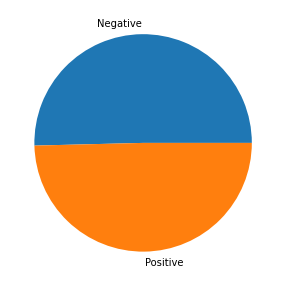

In [63]:
print("Negatives = ", len(labels[labels == 0]))
print("Positives = ", len(labels[labels == 1]))
print("--------------------------")
fig = plt.figure(figsize =(5, 5))
plot_data = [len(labels[labels == 0]), len(labels[labels == 1])]
plt.pie(plot_data, labels = ["Negative", "Positive"])

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(tokens, labels, test_size=0.2, random_state=42)

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

#we add a word index for the pad tokens
tokenizer.word_index['<PAD>'] = 0
print("Vocabulary size of the training={}".format(len(tokenizer.word_index)))
print("Number of Documents in the training={}".format(tokenizer.document_count))

Vocabulary size of the training=6452
Number of Documents in the training=9683


In [66]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
print(X_train[0].split())
print(train_sequences[0])

['desde', 'nuestro', 'estado', 'de', 'nimo', 'hasta', 'nuestro', 'sistema', 'inmunolgico', 'el', 'estilo', 'de', 'vida', 'vegano', 'nos', 'proporciona', 'una', 'gran', 'variedad', 'de', 'beneficios', 'para', 'la', 'saludel', 'veganismo', 'tiene', 'muchas', 'ventajas', 'para', 'nuestra', 'salud', 'tanto', 'para', 'nuestro', 'sistema', 'inmunolgico', 'como', 'para', 'nuestro', 'estado', 'de', 'nimo']
[126, 297, 609, 2, 362, 198, 297, 732, 982, 5, 759, 2, 741, 1010, 856, 808, 11, 72, 180, 2, 809, 17, 3, 2032, 1531, 99, 342, 1622, 17, 876, 545, 212, 17, 297, 732, 982, 18, 17, 297, 609, 2, 362]


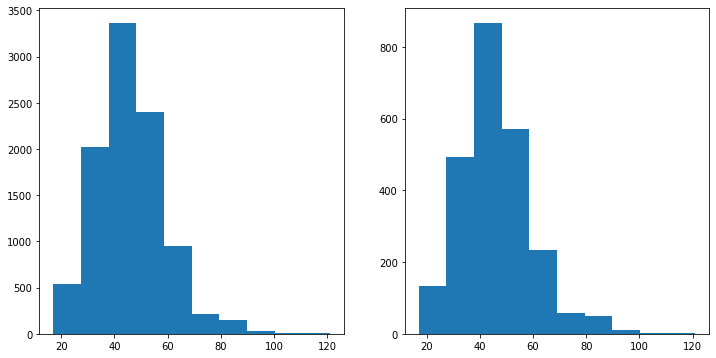

In [67]:
# The following graph shows the size distribution (number of tokens) of the review

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [68]:
MAX_SEQUENCE_LENGTH = 70

# pad dataset to a maximum review length in words
from tensorflow.keras.preprocessing import sequence

train_seq_pad = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_seq_pad = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_seq_pad.shape, test_seq_pad.shape

((9683, 70), (2421, 70))

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding


import tensorflow as tf
tf.random.set_seed(1)

VOCAB_SIZE = len(tokenizer.word_index)

EMBED_SIZE = 300
EPOCHS=20
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 70, 300)           1935600   
                                                                 
 conv1d_4 (Conv1D)           (None, 70, 64)            76864     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 35, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2240)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               573696    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                      

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


# Fit the model
model.fit(train_seq_pad, Y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1, callbacks=[earlyStopping]
          )

Epoch 1/20
69/69 [==============================] - 13s 185ms/step - loss: 0.5689 - acc: 0.6914 - val_loss: 0.4912 - val_acc: 0.7637
Epoch 2/20
69/69 [==============================] - 13s 189ms/step - loss: 0.3289 - acc: 0.8649 - val_loss: 0.3609 - val_acc: 0.8524
Epoch 3/20
69/69 [==============================] - 13s 188ms/step - loss: 0.1781 - acc: 0.9363 - val_loss: 0.3249 - val_acc: 0.8865
Epoch 4/20
69/69 [==============================] - 13s 186ms/step - loss: 0.1010 - acc: 0.9658 - val_loss: 0.2236 - val_acc: 0.9267
Epoch 5/20
69/69 [==============================] - 13s 186ms/step - loss: 0.0719 - acc: 0.9780 - val_loss: 0.2098 - val_acc: 0.9401
Epoch 6/20
69/69 [==============================] - 13s 186ms/step - loss: 0.0415 - acc: 0.9869 - val_loss: 0.2543 - val_acc: 0.9391
Epoch 7/20
69/69 [==============================] - 13s 188ms/step - loss: 0.0289 - acc: 0.9917 - val_loss: 0.2412 - val_acc: 0.9412
Epoch 8/20
69/69 [==============================] - 13s 186ms/step - 

In [72]:
predictions=model.predict(test_seq_pad) 
predictions.reshape(-1)
predictions = [1 if item >= 0.5 else 0 for item in predictions]
predictions[:10]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [73]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1206
           1       0.91      0.98      0.94      1215

    accuracy                           0.94      2421
   macro avg       0.94      0.94      0.94      2421
weighted avg       0.94      0.94      0.94      2421



In [74]:
pd.DataFrame(confusion_matrix(Y_test, predictions), index=labels, columns=labels)

,negative,positive
negative,1093,113
positive,29,1186
